# Amazon Reviews Dataset

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [3]:
train = pd.read_csv("./train_sampled_reviews.csv")
val = pd.read_csv("./val_sampled_reviews.csv")
test = pd.read_csv("./test_sampled_reviews.csv")

In [4]:
train_texts = train['Review'].to_numpy()
train_labels = train['Label'].to_numpy()
val_texts = val['Review'].to_numpy()
val_labels = val['Label'].to_numpy()
test_texts = test['Review'].to_numpy()
test_labels = test['Label'].to_numpy()

y_train = to_categorical(train_labels, 2)
y_val = to_categorical(val_labels, 2)
y_test = to_categorical(test_labels, 2)

# Universal Sentence Encoder

In [5]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

tf.random.set_seed(42)
model_USE = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
], name="model_USE")

model_USE.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

model_USE.summary()

Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 256830786 (979.73 MB)
Trainable params: 32962 (128.76 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [6]:
checkpoint_path = "/content/drive/MyDrive/advanced_project/models/use_best_model"
cc = ModelCheckpoint(filepath=checkpoint_path,
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True,
                     verbose=1)

In [7]:
model_USE_history = model_USE.fit(train_texts, y_train,
                                  epochs=10,
                                  validation_data=(val_texts, y_val),
                                  callbacks=[cc])

Epoch 1/10
748/750 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8604
Epoch 1: val_accuracy improved from -inf to 0.87306, saving model to /content/drive/MyDrive/advanced_project/models/use_best_model
750/750 [==============================] - 26s 31ms/step - loss: 0.3358 - accuracy: 0.8602 - val_loss: 0.2933 - val_accuracy: 0.8731
Epoch 2/10
748/750 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8781
Epoch 2: val_accuracy improved from 0.87306 to 0.88861, saving model to /content/drive/MyDrive/advanced_project/models/use_best_model
750/750 [==============================] - 21s 28ms/step - loss: 0.2903 - accuracy: 0.8781 - val_loss: 0.2744 - val_accuracy: 0.8886
Epoch 3/10
749/750 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8801
Epoch 3: val_accuracy did not improve from 0.88861
750/750 [==============================] - 14s 19ms/step - loss: 0.2828 - accuracy: 0.8802 - val_loss: 0.2697 - val_accuracy: 0.88

In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

113/113 [==============================] - 2s 15ms/step - loss: 0.2082 - accuracy: 0.9150


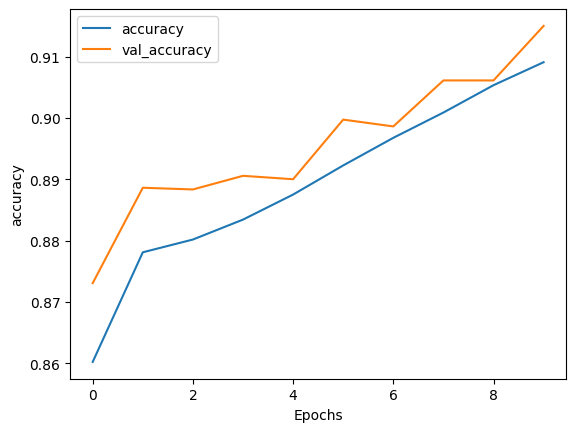

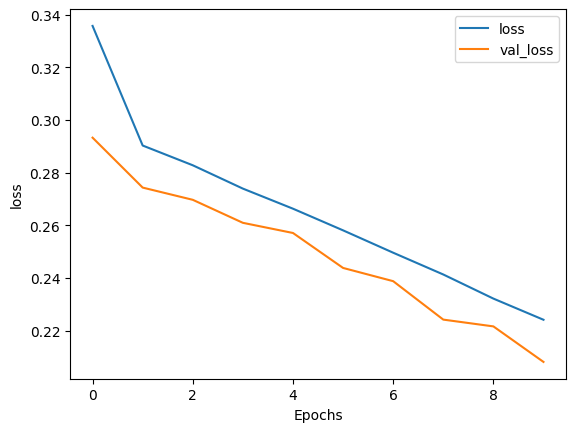

113/113 [==============================] - 2s 16ms/step


In [9]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model_USE = load_model(checkpoint_path)
model_USE.evaluate(val_texts, y_val)

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(model_USE_history, 'accuracy')
plot_graphs(model_USE_history, 'loss')

model_USE_pred_probs = model_USE.predict(val_texts)

model_USE_preds = tf.argmax(model_USE_pred_probs, axis=1)
model_USE_results = calculate_results(val_labels, model_USE_preds)


In [10]:
best_use = load_model(checkpoint_path)
score_use, acc_use = best_use.evaluate(val_texts, y_val, verbose=0)
print("Baseline USE Model on Amazon Reviews Dataset")
print(f'Test loss for USE model: {score_use:.3f}')
print(f'Test accuracy for USE model: {acc_use:.3f}')
print()

Baseline USE Model on Amazon Reviews Dataset
Test loss for USE model: 0.208
Test accuracy for USE model: 0.915



# Testing on Yelp

In [18]:
train = pd.read_csv("./yelp_train.csv")
val = pd.read_csv("./yelp_val.csv")
test = pd.read_csv("./yelp_test.csv")

train_texts = train['Review'].to_numpy()
train_labels = train['Label'].to_numpy()
val_texts = val['Review'].to_numpy()
val_labels = val['Label'].to_numpy()
test_texts = test['Review'].to_numpy()
test_labels = test['Label'].to_numpy()

y_train = to_categorical(train_labels, 2)
y_val = to_categorical(val_labels, 2)
y_test = to_categorical(test_labels, 2)

In [19]:
best_use_yelp_model = load_model(checkpoint_path)
score_use, acc_use = best_use_yelp_model.evaluate(val_texts, y_val, verbose=0)
print("Baseline USE Model on Yelp Dataset")
print(f'Test loss for USE model: {score_use:.3f}')
print(f'Test accuracy for USE model: {acc_use:.3f}')
print()

Baseline USE Model on Yelp Dataset
Test loss for USE model: 0.278
Test accuracy for USE model: 0.885



# Finetuning the Model on Yelp

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

model_use_finetuned = load_model(checkpoint_path)

optimizer = Adam(learning_rate=0.001)

model_use_finetuned.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

use_finetune_checkpoint_path = '/content/drive/MyDrive/advanced_project/models/use_finetuned_best_model'
use_finetune_checkpoint = ModelCheckpoint(
    filepath=use_finetune_checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

y_train_y = to_categorical(np.array(train_labels).astype('int'), 2)
y_val_y = to_categorical(np.array(val_labels).astype('int'), 2)

history_use_ft = model_use_finetuned.fit(
    train_texts, y_train_y,
    batch_size=256,
    validation_data=(val_texts, y_val_y),
    epochs=10,
    callbacks=[use_finetune_checkpoint]
)


Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9003
Epoch 1: val_accuracy improved from -inf to 0.90770, saving model to /content/drive/MyDrive/advanced_project/models/use_finetuned_best_model
104/104 [==============================] - 43s 379ms/step - loss: 0.2388 - accuracy: 0.9003 - val_loss: 0.2285 - val_accuracy: 0.9077
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9096
Epoch 2: val_accuracy improved from 0.90770 to 0.90928, saving model to /content/drive/MyDrive/advanced_project/models/use_finetuned_best_model
104/104 [==============================] - 38s 366ms/step - loss: 0.2193 - accuracy: 0.9096 - val_loss: 0.2218 - val_accuracy: 0.9093
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9132
Epoch 3: val_accuracy improved from 0.90928 to 0.91121, saving model to /content/drive/MyDrive/advanced_project/models/use_finetuned_best_model
104/104 [======

In [21]:
finetune_use_best = load_model(use_finetune_checkpoint_path)

y_test_y = np.array(test_labels)
y_test_y = y_test_y.astype('int')
y_test_y = to_categorical(y_test_y, 2)
score_use, acc_use = best_use.evaluate(test_texts, y_test_y, verbose=0)

print("Finetuned USE Model on Yelp Dataset")
print(f'Test loss for Fine-Tuned USE model: {score_use:.3f}')
print(f'Test accuracy for Fine-Tuned USE model: {acc_use:.3f}')
print()

Finetuned USE Model on Yelp Dataset
Test loss for Fine-Tuned USE model: 0.272
Test accuracy for Fine-Tuned USE model: 0.887



# Feature Extraction on the Model

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

pretrained_model = load_model(use_finetune_checkpoint_path)

dropout_rate = 0.5
x = Dropout(dropout_rate)(pretrained_model.layers[-2].output)
output = Dense(units=pretrained_model.layers[-1].units, activation=pretrained_model.layers[-1].activation)(x)
model = Model(inputs=pretrained_model.input, outputs=output)

for layer in model.layers[:-2]:
    layer.trainable = False

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

use_feature_extraction_checkpoint_path = '/content/drive/MyDrive/advanced_project/models/use_fe_best_model'
checkpoint = ModelCheckpoint(filepath=use_feature_extraction_checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

batch_size = 128

history = model.fit(
    train_texts, y_train_y,
    batch_size=batch_size,
    validation_data=(val_texts, y_val_y),
    epochs=10,
    callbacks=[checkpoint, lr_scheduler]
)


Epoch 1/10
208/208 [==============================] - 46s 194ms/step - loss: 0.4392 - accuracy: 0.8467 - val_loss: 0.3111 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 2/10
208/208 [==============================] - 38s 183ms/step - loss: 0.2809 - accuracy: 0.9077 - val_loss: 0.2518 - val_accuracy: 0.9061 - lr: 0.0010
Epoch 3/10
208/208 [==============================] - 36s 174ms/step - loss: 0.2461 - accuracy: 0.9085 - val_loss: 0.2325 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 4/10
208/208 [==============================] - 34s 166ms/step - loss: 0.2292 - accuracy: 0.9105 - val_loss: 0.2242 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 5/10
208/208 [==============================] - 35s 169ms/step - loss: 0.2203 - accuracy: 0.9118 - val_loss: 0.2202 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 6/10
208/208 [==============================] - 34s 164ms/step - loss: 0.2166 - accuracy: 0.9145 - val_loss: 0.2180 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 7/10
208/208 [==============================] 

In [23]:
use_feature_extraction_best_two = load_model(use_feature_extraction_checkpoint_path)

y_test_y = np.array(test_labels)
y_test_y = y_test_y.astype('int')
y_test_y = to_categorical(y_test_y, 2)
score_use, acc_use = best_use.evaluate(test_texts, y_test_y, verbose=0)

print("Feature Extraction USE Model on Yelp Dataset")
print(f'Test loss for Fine-Tuned USE model: {score_use:.3f}')
print(f'Test accuracy for Fine-Tuned USE model: {acc_use:.3f}')
print()

Feature Extraction USE Model on Yelp Dataset
Test loss for Fine-Tuned USE model: 0.272
Test accuracy for Fine-Tuned USE model: 0.887

